<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: If Fourier knew about neural networks?
by Fayyaz Minhas

This tutorial explores how Fourier transform can be viewed as a neural network. By treating the decomposition and reconstruction of signals as a learning process, we employ a neural network to approximate the discrete Fourier Transform (DFT), enabling the analysis and synthesis of signals in terms of their sinusoidal components.

Theoretical Background
Discrete Fourier Transform (DFT)
The DFT is a mathematical technique used to transform a discrete signal from the time domain into the frequency domain, decomposing it into a series of sinusoids of varying magnitudes and phases.

We consider a decomposition based view of the Fourier transform. Assume we are given a signal $x[m],m=0,...,N-1$ which can be represented by an N-dimensional vector $x$. We would like to decompose the signal into sinusoids as follows:

$$\hat{x}[m]=\frac{1}{N}\sum_{k=0}^{N-1} A_k(x;W)sin(2\pi m k/N+\phi_k(x;W))$$

Where $A_k(x;W)$ is the magnitude of the k-th frequency sinusoid and $\phi_k(x;W)$ is its phase. Naturally, the amplitude and phase are dependent upon the signal and we would like to recover them. For this purpose, we represent:

$$A_k(x;W)=\sqrt {(x^TW^{real}_k)^2+(x^TW^{imag}_k)^2}$$
$$\phi_k(x;W)=arctan(x^TW^{imag}_k,x^TW^{real}_k)$$

This can be achieved by minimization of the following objective function:

$$l(W;x)=\frac{1}{N} \sum_m (x[m]-\frac{1}{N}\sum_{k=0}^{N-1} A_k(x;W)sin(2\pi m k/N+\phi_k(x;W)))^2$$

We take a number of signals to obtain $W$, i.e.,

$$W^* = argmin_W \sum_x l(W;x)$$

$W^* = [W^{real} | W^{imag}]$ would be the $N\times 2N$ "Basis" matrix whose rows correspond to time steps and columns within each sub-matrices correspond to frequencies such that when its real and imaginary components are multiplied with the signal, we can get the magnitude and phase of  a given signal.

We can also build lower-rank approximation of this matrix.

In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F


class MatrixGenerator(nn.Module):
    def __init__(self, M, N):
        super(MatrixGenerator, self).__init__()
        # Define the two MxN learnable matrices
        self.matrix0 = nn.Parameter(0.01*torch.randn(N, N))
        #self.matrix1 = nn.Parameter(0.01*torch.randn(N, M))
        #self.matrix2 = nn.Parameter(0.01*torch.randn(M, 2*N))

    def forward(self,x = None):
        #transformed_matrix1 = self.matrix1
        #transformed_matrix2 = self.matrix2
        #output_matrix = F.tanh(transformed_matrix1@transformed_matrix2)
        output_matrix = self.matrix0
        return output_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters

N = 100
M = 200
# Convert arrays to tensors, move them to the specified device, and perform operations
tvals = torch.arange(N).view(-1, 1).float().to(device)  # Reshape and convert to float for division
freqs = torch.arange(N).view(1, -1).float().to(device)  # Reshape and convert to float for division
tf = 2 * torch.pi * tvals * freqs / N  # tf_(j,k) = 2*pi*(t_j)*(f_k) = 2pi(j)(k)/N (matrix of size NxN)
generator = MatrixGenerator(M=M, N=N).to(device)
generator_real = MatrixGenerator(M=M, N=N).to(device)
generator_imag = MatrixGenerator(M=M, N=N).to(device)
optimizer = torch.optim.SGD(list(generator_real.parameters()) + list(generator_imag.parameters()), lr=0.5)
#optimizer = torch.optim.SGD(generator.parameters(), lr=0.02)
losses = []
for i in tqdm(range(5000)):
    optimizer.zero_grad()
    x = (torch.randn(1, N)).to(device)
    # Generate W_real and W_imag matrices
    #gen_input = torch.randn(1, M).to(device)
    #W = generator()
    #W_real,W_imag = W[:,:N],W[:,N:]
    W_real = generator_real()
    W_imag = generator_imag()
    # Forward pass using W_real and W_imag from separate generators
    y_real = torch.mm(x, W_real)
    y_imag = torch.mm(x, W_imag)
    amplitudes = torch.sqrt(y_real**2 + y_imag**2) #A_k = sqrt((x*W^{imag}_k)**2+(x*W^{real}_k)**2) amplitude of the k-th sinusoid

    phases = torch.atan2(y_imag, y_real) # \phi_k = atan2(x*W^{imag}_k,x*W^{real}_k) phase of the k-th sinusoid
    sinusoids = amplitudes * torch.sin(tf + phases) # S^{k}[j] = A_k sin(2*pi*j*k/N + \phi_k) #each col is a sinusoid
    reconstructed_signal = (1/N)*torch.sum(sinusoids, axis=1) # x[j] = (1/N)*\sum_{k=0}^{N-1} S^{k}[j] = (1/N)*\sum_{k=0}^{N-1} A_k sin(2*pi*j*k/N + \phi_k)


    loss = torch.sum((x - reconstructed_signal) ** 2)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())


100%|██████████| 5000/5000 [00:15<00:00, 325.37it/s]


Reduction: 1.0


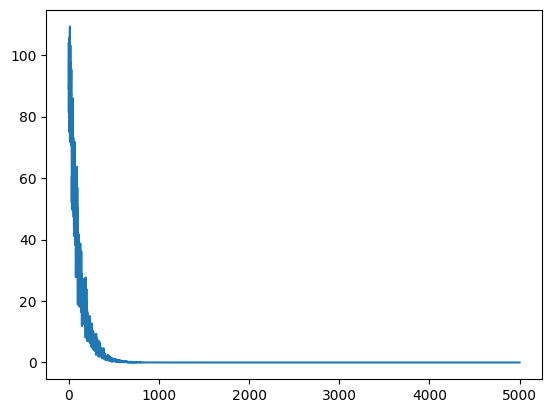

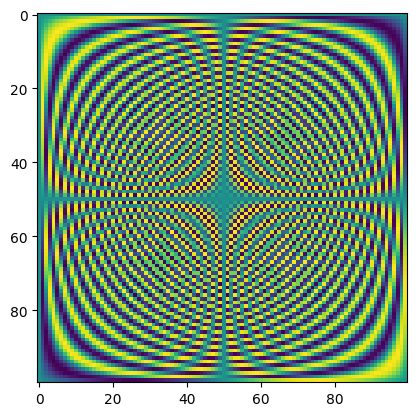

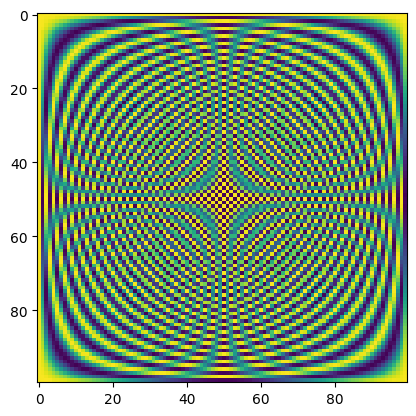

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = count_parameters(generator_real)+count_parameters(generator_imag)
#total_params = count_parameters(generator)

print(f"Reduction: {total_params/(N*N*2)}")

import matplotlib.pyplot as plt
plt.plot(losses);plt.show()
Wr = W_real.detach().cpu().numpy()
Wi = W_imag.detach().cpu().numpy()
plt.imshow(Wr);plt.show()
plt.imshow(Wi)
